In [191]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense,Dropout,Activation
from keras.optimizers import Adam
from keras.utils import np_utils
import math
import time
import matplotlib.pyplot as plt

In [247]:
# df_all = pd.read_csv('../rnn_data/all/2013_2018_price.csv',encoding='utf-8')
df_all = pd.read_csv('2012_2018_all.csv',encoding='utf-8')
df_c = df_all.groupby('證券代號').get_group('3209')

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5,6,7,8,9,10,25,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [248]:
df_c.columns.values

array(['Unnamed: 0', '三大法人買賣超股數', '外資自營商買賣超股數', '外資自營商買進股數', '外資自營商賣出股數',
       '外資買賣超股數', '外資買進股數', '外資賣出股數', '外陸資買賣超股數(不含外資自營商)',
       '外陸資買進股數(不含外資自營商)', '外陸資賣出股數(不含外資自營商)', '成交筆數', '成交股數', '成交金額',
       '投信買賣超股數', '投信買進股數', '投信賣出股數', '收盤價', '日期', '最低價', '最後揭示買價',
       '最後揭示買量', '最後揭示賣價', '最後揭示賣量', '最高價', '本益比', '漲跌(+/-)', '漲跌價差',
       '自營商買賣超股數', '自營商買賣超股數(自行買賣)', '自營商買賣超股數(避險)', '自營商買進股數',
       '自營商買進股數(自行買賣)', '自營商買進股數(避險)', '自營商賣出股數', '自營商賣出股數(自行買賣)',
       '自營商賣出股數(避險)', '證券代號', '證券名稱', '開盤價'], dtype=object)

In [249]:
# del df_c['三大法人買賣超股數']
del df_c['外資自營商買賣超股數']
del df_c['外資自營商買進股數']
del df_c['外資自營商賣出股數']
del df_c['外資買賣超股數']
del df_c['外資買進股數']
del df_c['外資賣出股數']
del df_c['外陸資買賣超股數(不含外資自營商)']
del df_c['外陸資買進股數(不含外資自營商)']
del df_c['外陸資賣出股數(不含外資自營商)']
del df_c['投信買賣超股數']
del df_c['投信買進股數']
del df_c['投信賣出股數']
del df_c['最後揭示買價']
del df_c['自營商買賣超股數']
del df_c['自營商買賣超股數(自行買賣)']
del df_c['自營商買賣超股數(避險)']
del df_c['自營商買進股數']
del df_c['最後揭示買量']
del df_c['最後揭示賣價']
del df_c['最後揭示賣量']
del df_c['自營商賣出股數']
del df_c['自營商買進股數(避險)']
del df_c['自營商賣出股數(自行買賣)']
del df_c['自營商賣出股數(避險)']
del df_c['自營商買進股數(自行買賣)']
# del df_c['自營商賣出股數(自行買賣)']
# del df_c['自營商賣出股數(避險)']

In [250]:
def batch_data(df_c,time_steps,seperate_rate,shift_days):
    del df_c['Unnamed: 0']
    del df_c['證券代號']
    del df_c['本益比']
    del df_c['成交金額']
    del df_c['證券名稱']
    empty_li = df_c[df_c['漲跌(+/-)']=='X'].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    empty_li = df_c[df_c['漲跌(+/-)']==' '].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    empty_li = df_c[df_c['收盤價']=='X'].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    empty_li = df_c[df_c['收盤價']==' '].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    df_c['成交筆數']=df_c['成交筆數'].str.replace(',','')
    df_c['成交股數']=df_c['成交股數'].str.replace(',','')
    df_c.三大法人買賣超股數 = df_c.三大法人買賣超股數.astype(str)
    df_c['三大法人買賣超股數']=df_c['三大法人買賣超股數'].str.replace(',','').str.replace('nan','0')
    df_c.收盤價 = df_c.收盤價.astype(str)
    df_c['收盤價']=df_c['收盤價'].str.replace(',','').str.replace('nan','0')
    df_c.三大法人買賣超股數 = df_c.三大法人買賣超股數.astype(float)
    df_c['三大法人買賣超股數'].fillna(0)
    df_c.成交筆數 = df_c.成交筆數.astype(float)
    df_c.成交股數 = df_c.成交股數.astype(float)
    df_c.收盤價 = df_c.收盤價.astype(float)
    df_c.最低價 = df_c.最低價.astype(float)
    df_c.最高價 = df_c.最高價.astype(float)
    df_c.開盤價 = df_c.開盤價.astype(float)
    df_c.漲跌價差 = df_c.漲跌價差.astype(float)
    df_c['return'] = np.where(df_c['漲跌(+/-)'] !='+',df_c['漲跌價差']*-1, df_c['漲跌價差'])
    df_c['return']=df_c['return'].shift(-1)
#     df_c['label'] = (df_c['return']+df_c['return'].shift(-7)+df_c['return'].shift(-6)+df_c['return'].shift(-5)+df_c['return'].shift(-4)+df_c['return'].shift(-3)+df_c['return'].shift(-2)+df_c['return'].shift(-1))/df_c['收盤價']*100
#     df_c['label'] = (df_c['return']+df_c['return'].shift(-2)+df_c['return'].shift(-1))/df_c['收盤價']*100
    df_c['label'] = (df_c['收盤價'].shift(-(shift_days))-df_c['收盤價'])/df_c['收盤價']*10
    df_c.label = df_c.label.astype(str)
    df_c['label']=df_c['label'].str.replace(',','').str.replace('nan','0')
    df_c.label = df_c.label.astype(float)
    print(df_c['label'].describe())
    plt.hist(df_c['label'])
    plt.show()
#     min_max_scaler = MinMaxScaler(feature_range=(-1,1))
    
#     df_c['label']=min_max_scaler.fit_transform(df_c['label'].fillna(0).reshape(-1,1))
#     df_c['label']=min_max_scaler.fit_transform(df_c['label'].reshape(-1,1))
    dd=df_c[['日期','收盤價','三大法人買賣超股數','成交股數']]
    del df_c['漲跌(+/-)']
    del df_c['漲跌價差']
    del df_c['return']
    d= df_c['日期']
    del df_c['日期']
    #remove feature
    del df_c['開盤價']
    print(df_c.columns.values)
    print(df_c.shape)
    min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    for i in range(len(df_c.columns)-1):
        df_c[df_c.columns[i]] =min_max_scaler.fit_transform(np.array(df_c[df_c.columns[i]]).reshape(-1,1))
    Y_batch = df_c['label']
    del df_c['label']
    X_batch = df_c
    X_batch = np.array(X_batch)
    Y_batch = np.array(Y_batch)
#     Y_batch = np_utils.to_categorical(Y_batch)
    n = len(X_batch)
    drop_n = n%time_steps
    X_batch_t=[]
    Y_batch_t=[]
    for i in range(0,len(X_batch)-time_steps):
        X_batch_t.append(X_batch[i:i+time_steps])
        Y_batch_t.append(Y_batch[i+time_steps])
    train_size = math.ceil(len(X_batch_t)*seperate_rate)
    X_batch_t_train =  X_batch_t[:train_size]
    Y_batch_t_train = Y_batch_t[:train_size]
    X_batch_t_test = X_batch_t[train_size:]
    Y_batch_t_test = Y_batch_t[train_size:]
    X_batch_t_train=np.array(X_batch_t_train)
    Y_batch_t_train=np.array(Y_batch_t_train)
    X_batch_t_test=np.array(X_batch_t_test)
    Y_batch_t_test=np.array(Y_batch_t_test)
    return X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,dd

In [251]:
def g_b(X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,BATCH_SIZE):
    X_batch_t_train_b=[]
    Y_batch_t_train_b=[]
    dn= (X_batch_t_train.shape[0])%BATCH_SIZE
    for i in range(dn,X_batch_t_train.shape[0],BATCH_SIZE):
        X_batch_t_train_b.append(X_batch_t_train[i:i+BATCH_SIZE])
        Y_batch_t_train_b.append(Y_batch_t_train[i:i+BATCH_SIZE])
    X_batch_t_train_b=np.array(X_batch_t_train_b)
    Y_batch_t_train_b=np.array(Y_batch_t_train_b)
    dn= (X_batch_t_test.shape[0])%BATCH_SIZE
    X_batch_t_test_b=[]
    Y_batch_t_test_b=[]
    
    for i in range(dn,X_batch_t_test.shape[0],BATCH_SIZE):
        X_batch_t_test_b.append(X_batch_t_test[i:i+BATCH_SIZE])
        Y_batch_t_test_b.append(Y_batch_t_test[i:i+BATCH_SIZE])
    X_batch_t_test_b=np.array(X_batch_t_test_b)
    Y_batch_t_test_b=np.array(Y_batch_t_test_b) 
    return X_batch_t_train_b,Y_batch_t_train_b,X_batch_t_test_b,Y_batch_t_test_b

In [252]:
time_steps=15
seperate_rate=0.7
TIME_STEPS = time_steps
LR = 0.0001
shift_days=3

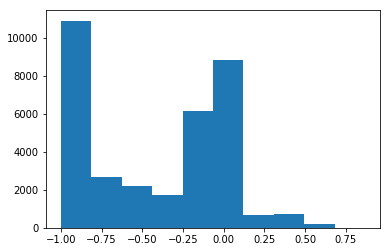

In [253]:
plt.hist(X_batch_t_test.flatten())
plt.show()

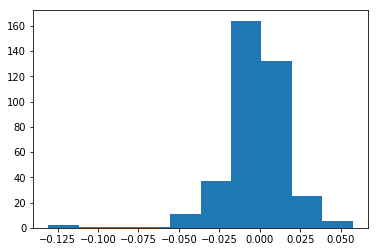

In [254]:
plt.hist(Y_batch_t_test.flatten())
plt.show()

count    1280.000000
mean       -0.000766
std         0.291742
min        -1.389365
25%        -0.126733
50%        -0.015540
75%         0.121258
max         1.493849
Name: label, dtype: float64


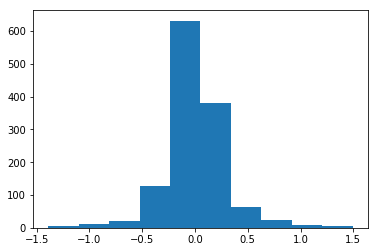

['三大法人買賣超股數' '成交筆數' '成交股數' '收盤價' '最低價' '最高價' 'label']
(1280, 7)


In [255]:
X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,dd=batch_data(df_c,time_steps,seperate_rate,shift_days)

In [256]:
print(X_batch_t_train.shape,X_batch_t_test.shape)

(886, 15, 6) (379, 15, 6)


In [257]:
INPUT_SIZE = X_batch_t_train.shape[2]
BATCH_SIZE=127

In [258]:
X_batch_t_train_b,Y_batch_t_train_b,X_batch_t_test_b,Y_batch_t_test_b=g_b( X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,BATCH_SIZE)

In [259]:
INPUT_SIZE = 6
CELL_SIZE = 30
OUTPUT_SIZE=16
LR = 0.0001*0.5
epoch = 2001

In [260]:
model =Sequential()
model.add(LSTM(
    batch_input_shape=(BATCH_SIZE,TIME_STEPS, INPUT_SIZE),
    output_dim=256,
    return_sequences=False,
    stateful=True,
))
# model.add(Dense(batch_input_shape=BATCH_SIZE*TIME_STEPS,activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(8))
model.add(Dense(1))
adam = Adam(LR)
model.compile(optimizer=adam,
              loss='mse')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(127, 15, ..., return_sequences=False, stateful=True, units=256)`
  


In [261]:
X_batch_t_test_b[-1].shape

(127, 15, 6)

In [262]:
cl = []
start_time = time.time()
cl_chart=[]
for epoch in range(epoch):
    for i in range(X_batch_t_train_b.shape[0]):
#         print(X.shape)
        X = X_batch_t_train_b[i].reshape(BATCH_SIZE,TIME_STEPS,INPUT_SIZE)
        Y = Y_batch_t_train_b[i].reshape(BATCH_SIZE,1)
        cost = model.train_on_batch(X,Y)
#         pred = model.predict_class(X,Y)
#         pred = model.predict(X, 1)
#         cl_chart.append(cost)
#         if cost<20:
#             cl.append(cost)
        cl.append(cost)
    if epoch % 100  == 0:
        print('cl',np.average(cl))
        print('train cost: ', cost,'epoch: ',epoch)
#         print('class',pred)
        cl=[]
t=(start_time-time.time())*-1
print('耗時:'+str(t)+'s')

cl 0.1432805
train cost:  0.08148102 epoch:  0
cl 0.1026202
train cost:  0.05188675 epoch:  100
cl 0.098005235
train cost:  0.051566992 epoch:  200
cl 0.09649413
train cost:  0.052210588 epoch:  300
cl 0.09448597
train cost:  0.05631698 epoch:  400
cl 0.09190374
train cost:  0.05596251 epoch:  500
cl 0.08786156
train cost:  0.058302294 epoch:  600
cl 0.08568423
train cost:  0.055521235 epoch:  700
cl 0.083360784
train cost:  0.0548766 epoch:  800
cl 0.08048886
train cost:  0.046174943 epoch:  900
cl 0.07693875
train cost:  0.049754154 epoch:  1000
cl 0.07345274
train cost:  0.047923643 epoch:  1100
cl 0.07340134
train cost:  0.049941055 epoch:  1200
cl 0.069396004
train cost:  0.047911506 epoch:  1300
cl 0.06778014
train cost:  0.048091758 epoch:  1400
cl 0.06416303
train cost:  0.04714804 epoch:  1500
cl 0.06205584
train cost:  0.04831189 epoch:  1600
cl 0.06019938
train cost:  0.04106275 epoch:  1700
cl 0.057658933
train cost:  0.03885521 epoch:  1800
cl 0.05840881
train cost:  0.037

In [218]:
yhat=[]
for i in range((X_batch_t_test_b).shape[0]):
    yhat.append(model.predict_on_batch((X_batch_t_test_b[i])))
yhat = np.array(yhat)

In [219]:
# for i in range((X_batch_t_test_b).shape[0]):
#     cost = model.train_on_batch(X_batch_t_test_b[i],Y_batch_t_test_b[i])
#     print(cost)

In [220]:
yhat=yhat.flatten()
Y_batch_t_test_b=Y_batch_t_test_b.flatten()

In [221]:
for i in range(-1,-1*(shift_days+1),-1):
    Y_batch_t_test_b[i]=Y_batch_t_test_b[-1*(shift_days+1)]

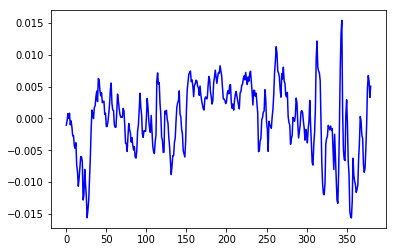

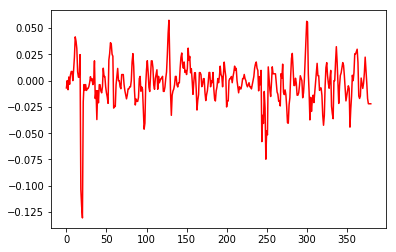

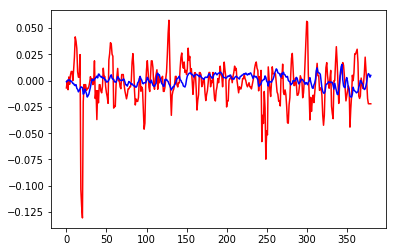

mse: 0.000416613133731158


In [222]:
#results
yhat=np.array(yhat).flatten()
plt.plot(yhat,color='blue')
plt.show()
plt.plot(Y_batch_t_test_b,color='red')
plt.show()
plt.plot(Y_batch_t_test_b,color='red')
plt.plot(yhat,color='blue')
plt.show()
print('mse: '+str(np.average((yhat-Y_batch_t_test_b)**2)))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


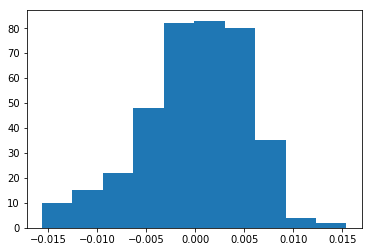

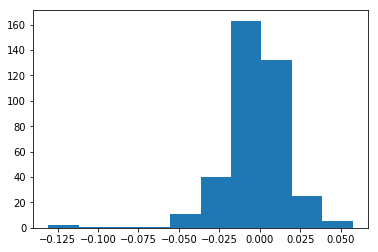

count    381.000000
mean      -0.000087
std        0.005401
min       -0.015610
25%       -0.003156
50%        0.000477
75%        0.003944
max        0.015399
Name: s, dtype: float64

In [229]:
df_c_p = dd[-(yhat.shape[0]):]
df_c_p['s']=yhat
df_c_p['y']=Y_batch_t_test_b
plt.hist(df_c_p['s'])
plt.show()
plt.hist(df_c_p['y'])
plt.show()
df_c_p['s'].describe()

In [234]:
s = 0
own=0
trade_record=[]
profit=[]
for i in range(df_c_p.shape[0]):
    price = float(df_c_p.iloc[i]['收盤價'])
    signal = df_c_p.iloc[i]['s']
    date=df_c_p.iloc[i]['日期']
    if own==0 :
        if signal>s:
            own=1
            trade_record.append([i,'buy',price,date,signal])
    if own>0:
        if i-trade_record[-1][0]<shift_days:
            if signal<-s:
                own=0
                profit.append(price-trade_record[-1][2])
                trade_record.append([i,'sell',price,date,signal])
        elif i-trade_record[-1][0]==shift_days:
            own=0
            profit.append(price-trade_record[-1][2])
            trade_record.append([i,'sell',price,date,signal])
print('profit: '+str(sum(profit)))

profit: -2.100000000000012


In [235]:
trade_record

[[2, 'buy', 28.9, 20160608.0, 0.0007428146782331169],
 [3, 'sell', 28.6, 20160613.0, -1.7051395843736827e-05],
 [4, 'buy', 28.75, 20160614.0, 0.0008109576883725822],
 [5, 'sell', 28.65, 20160615.0, -0.0010052404832094908],
 [32, 'buy', 26.45, 20160801.0, 0.0013022639323025942],
 [34, 'sell', 26.4, 20160803.0, -1.5717741916887462e-05],
 [35, 'buy', 26.5, 20160804.0, 0.0017035857308655977],
 [38, 'sell', 27.0, 20160810.0, 0.004283866845071316],
 [39, 'buy', 26.0, 20160811.0, 0.0026404105592519045],
 [42, 'sell', 25.75, 20160816.0, 0.004324723966419697],
 [43, 'buy', 25.55, 20160817.0, 0.003543908940628171],
 [46, 'sell', 25.3, 20160822.0, 0.0026443630922585726],
 [47, 'buy', 25.6, 20160823.0, 0.002706206636503339],
 [50, 'sell', 25.7, 20160826.0, -0.0012826330494135618],
 [53, 'buy', 25.4, 20160831.0, 0.0007172554614953697],
 [56, 'sell', 25.9, 20160905.0, 0.005538596771657467],
 [57, 'buy', 25.85, 20160906.0, 0.0023616787511855364],
 [60, 'sell', 26.5, 20160909.0, -0.001008379040285945]

In [236]:
profit

[-0.29999999999999716,
 -0.10000000000000142,
 -0.05000000000000071,
 0.5,
 -0.25,
 -0.25,
 0.09999999999999787,
 0.5,
 0.6499999999999986,
 0.09999999999999787,
 -0.15000000000000213,
 0.25,
 0.05000000000000071,
 0.25,
 0.04999999999999716,
 0.25,
 0.10000000000000142,
 -0.15000000000000213,
 -0.10000000000000142,
 -0.10000000000000142,
 0.14999999999999858,
 0.6000000000000014,
 -0.3500000000000014,
 -0.1999999999999993,
 0.1999999999999993,
 -0.09999999999999787,
 -0.5,
 0.1999999999999993,
 -0.05000000000000071,
 -0.5,
 -0.05000000000000071,
 0.10000000000000142,
 0.25,
 -0.5,
 0.09999999999999787,
 0.34999999999999787,
 -0.15000000000000213,
 -0.20000000000000284,
 0.15000000000000213,
 -0.15000000000000213,
 -0.15000000000000213,
 0.10000000000000142,
 0.3500000000000014,
 -0.8500000000000014,
 -0.6499999999999986,
 0.3000000000000007,
 0.14999999999999858,
 -0.4499999999999993,
 0.05000000000000071,
 -0.1999999999999993,
 -0.4499999999999993,
 0.3000000000000007,
 0.05000000000